<a href="https://colab.research.google.com/github/minhluu99/Text-Driven-Face-Image-Manipulation/blob/master/StyleCLIP_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/Shareddrives/StyleCLIP/Original_image /content/

Mounted at /content/drive


In [ ]:
#@title Setup (may take a few minutes)

Dir_dict = dict()
Dir_dict['Env_Dir'] = '/content/drive/Shareddrives/image_manipulation'
Dir_dict['CLIP_Dir'] = '/content/drive/Shareddrives/StyleCLIP/StyleCLIP_global'
if Dir_dict['CLIP_Dir'] == '':
  Dir_dict['CLIP_Dir'] = Dir_dict['Env_Dir'] + '/StyleCLIP_global'
Dir_dict['Style_Dir'] = '/content/drive/Shareddrives/styleGAN/stylegan_optimizer'
print('Dir_dict[Env_Dir] = {}'.format(Dir_dict['Env_Dir']))
print('Dir_dict[CLIP_Dir] = {}'.format(Dir_dict['CLIP_Dir']))

import os
os.chdir(Dir_dict['Env_Dir'])
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

if not os.path.exists(CODE_DIR):
  !git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
if not os.path.exists(Dir_dict['CLIP_Dir']):
  global_dir = Dir_dict['CLIP_Dir']
  ! git clone https://github.com/orpatashnik/StyleCLIP $global_dir
if not os.path.exists(Dir_dict['Env_Dir']+'/ninja-linux.zip'):
  !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
if not os.path.exists('/usr/local/bin/ninja'):
  !sudo unzip ninja-linux.zip -d /usr/local/bin/
  !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

% cd
% cd /content/

! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
!pip install transformers



Dir_dict[Env_Dir] = /content/drive/Shareddrives/image_manipulation
Dir_dict[CLIP_Dir] = /content/drive/Shareddrives/StyleCLIP/StyleCLIP_global
TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:19tcmalloc: large alloc 1147494400 bytes == 0x55933e7ca000 @  0x7f844d4c5615 0x5593052404cc 0x55930532047a 0x5593052432ed 0x559305334e1d 0x5593052b6e99 0x5593052b19ee 0x559305244bda 0x5593052b6d00 0x5593052b19ee 0x559305244bda 0x5593052b3737 0x559305335c66 0x5593052b2daf 0x559305335c66 0x5593052b2daf 0x559305335c66 0x5593052b2daf 0x559305245039 0x559305288409 0x559305243c52 0x5593052b6c25 0x5593052b19ee 0x559305244bda 0x5593052b3737 0x5593052b19ee 0x559305244bda 0x5593052b2915 0x559305244afa 0x5593052b2c0d 0x5593052b19ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x559382e20000 @  0x7f844d4c5615 0x5593052404cc 0x5593053

# **GAN inversion: E4E**

In [ ]:
#@title e4e setup
#@markdown * điền ffhq khi dùng model sẵn, "addr" cho custom model
#@markdown * ví dụ: /content/drive/Shareddrives/image_manipulation/e4e_ckpt/T4/checkpoints/iteration_95000.pt
experiment_type = "/content/drive/Shareddrives/image_manipulation2/e4e_ckpt/T15/checkpoints/iteration_54000.pt" #@param{type:'string'}

import os

Dir_dict = dict()
Dir_dict['Env_Dir'] = '/content/drive/Shareddrives/image_manipulation'
Dir_dict['CLIP_Dir'] = '/content/drive/Shareddrives/StyleCLIP/StyleCLIP_global'
if Dir_dict['CLIP_Dir'] == '':
  Dir_dict['CLIP_Dir'] = Dir_dict['Env_Dir'] + '/StyleCLIP_global'
Dir_dict['Style_Dir'] = '/content/drive/Shareddrives/styleGAN/stylegan_optimizer'
print('Dir_dict[Env_Dir] = {}'.format(Dir_dict['Env_Dir']))
print('Dir_dict[CLIP_Dir] = {}'.format(Dir_dict['CLIP_Dir']))
os.chdir(Dir_dict['Env_Dir'])
CODE_DIR = 'encoder4editing'

os.chdir(Dir_dict['Env_Dir'] + '/' + CODE_DIR)

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

os.chdir(Dir_dict['Env_Dir'])
if not os.path.exists(f'{CODE_DIR}/pretrained_models/e4e_ffhq_encode.pt'):
  from gdown import download as drive_download
  drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", f'{CODE_DIR}/pretrained_models/e4e_ffhq_encode.pt', quiet=False)


os.chdir(f'{CODE_DIR}')

EXPERIMENT_ARGS = {
        "model_path": "/content/drive/Shareddrives/image_manipulation/encoder4editing/pretrained_models/e4e_ffhq_encode.pt" \
          if experiment_type == "" else experiment_type
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts'] 
del ckpt
# import pprint
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
del opts
net.eval()
net.cuda()
print('Model successfully loaded!')

if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir('pretrained_models'):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

Dir_dict[Env_Dir] = /content/drive/Shareddrives/image_manipulation
Dir_dict[CLIP_Dir] = /content/drive/Shareddrives/StyleCLIP/StyleCLIP_global
Loading e4e over the pSp framework from checkpoint: /content/drive/Shareddrives/image_manipulation2/e4e_ckpt/T15/checkpoints/iteration_54000.pt
Model successfully loaded!


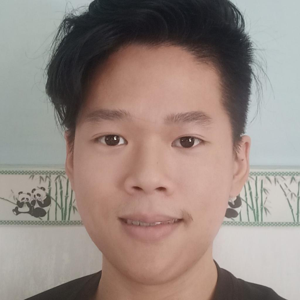

In [ ]:
#@title Align image
image_path = "/content/Original_image/image0014.png" #@param {type: "string"}
resize_dims = "300 300" #@param{type:'string'}
resize_dims = tuple([int(x) for x in resize_dims.split()])
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("pretrained_models/shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

Align = False #@param{type:'boolean'}
if Align == True :
  input_image = run_alignment(image_path)
else:
  input_image = original_image
 
input_image.save('/content/orginal.jpg')
input_image.resize(resize_dims)

torch.Size([1, 18, 512])


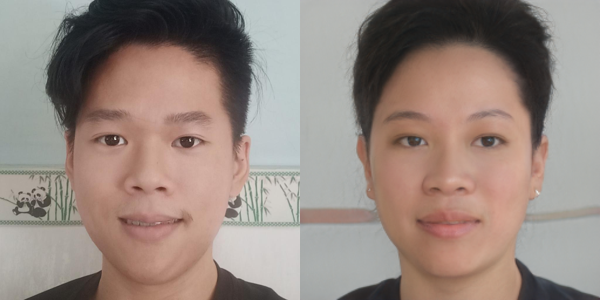

In [ ]:
#@title Invert the image with E4e
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, '/content/latents.pt')
print(latents.size())

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

# **Vòng lặp tối ưu**

In [ ]:
#@title Optimizer setup
%cd /content/drive/Shareddrives/styleGAN/stylegan_optimizer

import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks
network_pkl = "/content/drive/Shareddrives/styleGAN/stylegan2-colab/stylegan2/results/00001-pretrained/network-snapshot-10000.pkl"

print('Loading networks from "%s"...' % network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

import dataset_tool

import run_projector
import projector
import training.dataset
import training.misc
import os 
import pickle
def project_real_images(dataset_name, data_dir,data_out, num_images, num_snapshots):
    proj = projector.Projector()
    proj.set_network(Gs)

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, verbose=True, repeat=False, shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        os.makedirs(data_out + '/image%04d/' % image_idx)
        run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path(data_out + '/image%04d/' % image_idx), num_snapshots=num_snapshots)
        # --- Custom Change ---
        with open('/content/latent.pkl', 'wb') as out_file:
            pickle.dump(proj.get_dlatents(), out_file)

!mkdir /content/records
!mkdir /content/image

/content/drive/Shareddrives/styleGAN/stylegan_optimizer
Loading networks from "/content/drive/Shareddrives/styleGAN/stylegan2-colab/stylegan2/results/00001-pretrained/network-snapshot-10000.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
mkdir: cannot create directory ‘/content/records’: File exists
mkdir: cannot create directory ‘/content/image’: File exists


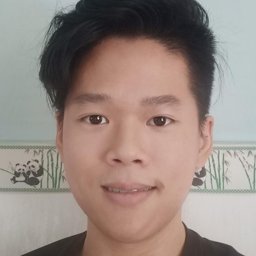

In [ ]:
#@title Align image
image_path = "/content/Original_image/image0014.png" #@param {type: "string"}
resize_dims = "256 256" #@param{type:'string'}
resize_dims = tuple([int(x) for x in resize_dims.split()])
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("pretrained_models/shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

Align = False #@param{type:'boolean'}
if Align == True :
  input_image = run_alignment(image_path)
else:
  input_image = original_image
 
input_image.resize(resize_dims)

Loading images from "/content/Optimizer_dir"
Creating dataset "/content/records"
Added 1 images.
rm: cannot remove '/content/image/image0000/': No such file or directory
Loading images from "records"...
Streaming data using training.dataset.TFRecordDataset...
Dataset shape = [3, 1024, 1024]
Dynamic range = [0, 255]
Label size    = 0
Projecting image 0/1 ...


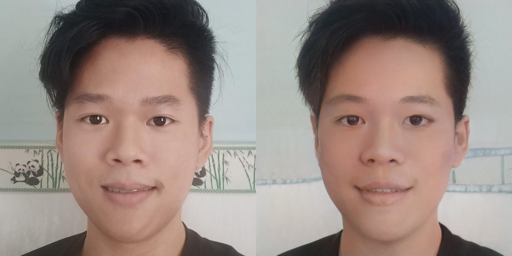

In [ ]:
#@title Invert the image with Optimizer
!rm -r /content/Optimizer_dir
!mkdir /content/Optimizer_dir
!cp $image_path /content/Optimizer_dir

dataset_tool.create_from_images("/content/records", '/content/Optimizer_dir', True)
!rm -r '/content/image/image0000/'
project_real_images("records","/content/","/content/image",1,100)
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)
result_image = Image.open('/content/image/image0000/step1000.png')
source_image = Image.open('/content/image/image0000/target.png')
source_image.save('/content/orginal.jpg')

display_alongside_source_image(result_image, source_image)

In [ ]:
#@markdown những code hỗ trợ viết báo cáo
# #tạo thư mục latent cho E4e result
# image_folder = '/content/drive/Shareddrives/StyleCLIP/e4e_result/real_dir'

# for i in os.listdir(image_folder):
#   image_path = image_folder + '/' +i
#   original_image = Image.open(image_path)
#   original_image = original_image.convert("RGB")
#   input_image = original_image
#   input_image.resize(resize_dims)
#   img_transforms = EXPERIMENT_ARGS['transform']
#   transformed_image = img_transforms(input_image)
#   with torch.no_grad():
#     images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
#     result_image, latent = images[0], latents[0]
#   torch.save(latents, '/content/drive/Shareddrives/StyleCLIP/e4e_latent_result/no_finetune/{}.pt'.format(i.replace('.jpg','')))
#   # tạo thư mục ảnh cho E4e result
# image_folder = '/content/drive/Shareddrives/StyleCLIP/e4e_result/real_dir'
# os.makedirs('/content/drive/Shareddrives/StyleCLIP/e4e_result/inverted_finetune/')
# for i in os.listdir(image_folder):
#   image_path = image_folder + '/' +i
#   original_image = Image.open(image_path)
#   original_image = original_image.convert("RGB")
#   input_image = original_image
#   input_image.resize(resize_dims)
#   img_transforms = EXPERIMENT_ARGS['transform']
#   transformed_image = img_transforms(input_image)
#   with torch.no_grad():
#     images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
#     result_image, latent = images[0], latents[0]
#   tensor2im(result_image).save('/content/drive/Shareddrives/StyleCLIP/e4e_result/inverted_finetune/'+i)




# **StyleCLIP**
 

In [ ]:
Dir_dict = dict()
Dir_dict['Env_Dir'] = '/content/drive/Shareddrives/image_manipulation'
Dir_dict['CLIP_Dir'] = '/content/drive/Shareddrives/StyleCLIP/StyleCLIP_global'
if Dir_dict['CLIP_Dir'] == '':
  Dir_dict['CLIP_Dir'] = Dir_dict['Env_Dir'] + '/StyleCLIP_global'
Dir_dict['Style_Dir'] = '/content/drive/Shareddrives/styleGAN/stylegan_optimizer'
print('Dir_dict[Env_Dir] = {}'.format(Dir_dict['Env_Dir']))
print('Dir_dict[CLIP_Dir] = {}'.format(Dir_dict['CLIP_Dir']))
import os

dataset_name='ffhq' #@param ['ffhq','ffhq_finetune'] {allow-input: true}
# input dataset name
global_dir = Dir_dict['CLIP_Dir']  + '/global_directions/'
% cd
% cd $global_dir

# input prepare data 
dir = 'npy/{}/'.format(dataset_name)
if not (os.path.exists(dir + 'W.npy') \
        and os.path.exists(dir + 'S_mean_std') \
        and os.path.exists(dir + 'S') \
        and os.path.exists(dir + 'fs3.npy')):
  !python GetCode.py --dataset_name $dataset_name --code_type 'w' 
  !python GetCode.py --dataset_name $dataset_name --code_type 's' 
  !python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 
import sys
sys.path.append(Dir_dict['CLIP_Dir'] +'/MultilingualCLIP')
sys.path.append('..')
import tensorflow as tf
print(tf.__version__)
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator


from src import multilingual_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 
text_model = multilingual_clip.load_model('M-BERT-Base-ViT-B')

M=Manipulator(dataset_name='ffhq')
fs3=np.load('./{}fs3.npy'.format(dir))
np.set_printoptions(suppress=True)

image_path = None
img_index = None

Dir_dict[Env_Dir] = /content/drive/Shareddrives/image_manipulation
Dir_dict[CLIP_Dir] = /content/drive/Shareddrives/StyleCLIP/StyleCLIP_global
/root
/content/drive/Shareddrives/StyleCLIP/StyleCLIP_global/global_directions
1.15.2


100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 20.6MiB/s]


Downloading:   0%|          | 0.00/297 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (

# Choose Mode (and show input image)

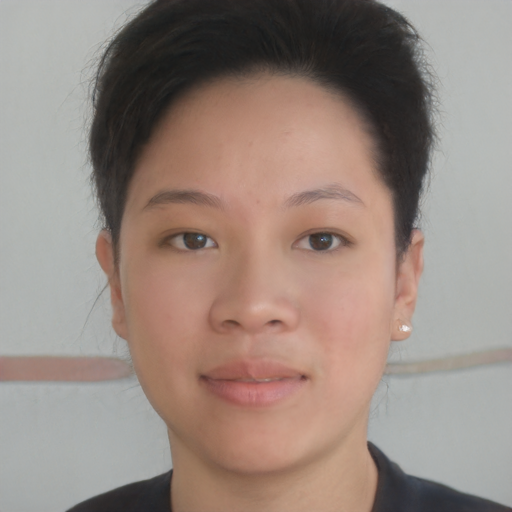

In [ ]:
mode='real image' #@param ['real image', 'generated image']
img_index =  1

from pathlib import Path
def get_final_Optimizer_latents():
    result_dir = '/content/drive/Shareddrives/StyleGAN_Optimization/Image_out_finetune'+'/latent_code/'
    latent_files = os.listdir(result_dir)
    latent_files.sort()

    all_final_latents =[]
    for file in latent_files:
      with open(result_dir + file,mode='rb') as latent_pickle:
        all_final_latents.append(pickle.load(latent_pickle))
    return all_final_latents

Optimization = False  #@param {type:'boolean'}
index =   14#@param {type:'number'}
import pickle
if mode == 'real image':
  img_index = 0
  if Optimization == False:
    latents=torch.load('/content/latents.pt')
    w_plus=latents.cpu().detach().numpy()
    original_image = Image.open('/content/orginal.jpg')
  else:
    # with open('/content/latent.pkl','rb') as f:
    #   latent_codes = pickle.load(f)
    latent_codes=[]
    dirr = '/content/drive/Shareddrives/StyleGAN_Optimization/Image_out/latent_code/'
    for i in os.listdir(dirr):
      with open(os.path.join(dirr,i),'rb') as f:
        latent_codes.append(pickle.load(f))
    w_plus = np.asarray(latent_codes[index])
    dirr = '/content/drive/Shareddrives/StyleGAN_Optimization/Image_out/'
    original_image = []
    for i in os.listdir(dirr):
      original_image.append(os.path.join(dirr,i))
    original_image.sort()
    original_image = Image.open('{}/target.png'.format(original_image[index]))

  dlatents_loaded=M.W2S(w_plus)
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]

elif mode == 'generated image':
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


In [ ]:
#@markdown #**Lời mô tả**
neutral='face with hair' #@param {type:"string"}
target='face with red hair' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model,text_model)
neutral2='khu\xF4n m\u1EB7t v\u1EDBi m\xE1i t\xF3c' #@param {type:"string"}
target2='khu\xF4n m\u1EB7t v\u1EDBi m\xE1i t\xF3c m\xE0u \u0111\u1ECF' #@param {type:"string"}
dt2=GetDt(classnames,model,text_model,VN=True)
print('{}\n{}\n{}\n{}\n'.format(neutral,target,neutral2,target2))

0.5444
0.48695597
face with hair
face with red hair
khuôn mặt với mái tóc
khuôn mặt với mái tóc màu đỏ



num of channels being manipulated: 59
num of channels being manipulated: 41


(-0.5, 1023.5, 1023.5, -0.5)

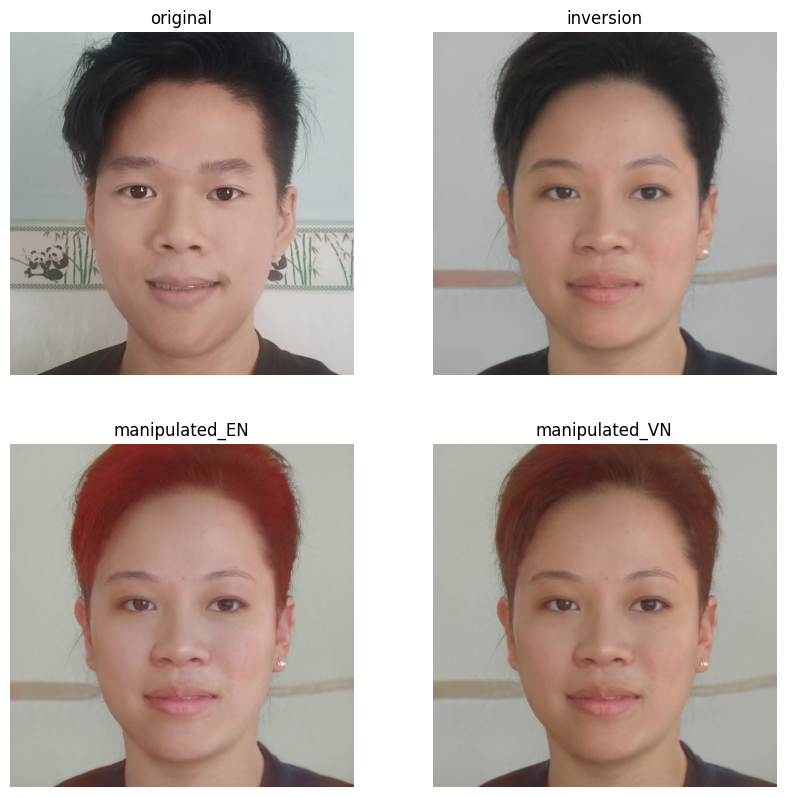

In [ ]:

#beta=0.1
#alpha=1
beta = 0.13 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 5.1 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

# betaVN = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
# alphaVN = 1.4 #@param {type:"slider", min:-10, max:10, step:0.1}
# M.alpha=[alphaVN]
# boundary_tmp2,c=GetBoundary(fs3,dt2,M,threshold=betaVN)
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt2,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated2=Image.fromarray(out[0,0])#.resize((512,512))


%matplotlib inline
plt.figure(figsize=(10,10), dpi= 100)
plt.subplot(2,2,1)
plt.imshow(original_image)
plt.title('original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(original)
plt.title('inversion')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(generated)
plt.title('manipulated_EN')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(generated2)
plt.title('manipulated_VN')
plt.axis('off')